**1. Data Collection & Preparation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
from tqdm.notebook import tqdm
from transformers import (
    AutoModel,
    AutoTokenizer,
    BertTokenizer,
    pipeline,
    LineByLineTextDataset,
    EncoderDecoderModel,
    BertConfig,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
tqdm.pandas()

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {device} ({torch.cuda.get_device_name(0) if device>=0 else 'CPU'})")

c:\Users\daffa\Documents\project-indoai\Project 2\env-data\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: 0 (NVIDIA GeForce RTX 3070)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daffa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daffa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\daffa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Exploratory Data Analysis (EDA)

In [2]:
import os
import json

#deklarasi path
# train_dir = r"D:\Bootcamp NLP\Materi Bootcamp\Natural Language Processing (NLP)\Project NLP\Text Summarization\Dataset\liputan6_data\canonical\train"
# validate_dir = r"D:\Bootcamp NLP\Materi Bootcamp\Natural Language Processing (NLP)\Project NLP\Text Summarization\Dataset\liputan6_data\canonical\dev"
# test_dir = r"D:\Bootcamp NLP\Materi Bootcamp\Natural Language Processing (NLP)\Project NLP\Text Summarization\Dataset\liputan6_data\canonical\test"

#buat direktori daffa (di comment aja nanti kak dede)
train_dir = r"D:\project-indoai\Project 2\liputan6_data\liputan6_data\canonical\train"
validate_dir = r"D:\project-indoai\Project 2\liputan6_data\liputan6_data\canonical\dev"
test_dir = r"D:\project-indoai\Project 2\liputan6_data\liputan6_data\canonical\test"

#buat fungsi untuk sekali parsing masing2 folder JSON ke DataFrame
def parsing_folder(folder):
    data = [] #list yg bakal nampung data JSON
    print(f"Sedang proses folder{folder}")

    #looping proses parsing 
    for file_name in os.listdir(folder):
        if file_name.endswith(".json"):
            file_path = os.path.join(folder, file_name)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data.append(json.load(f))
            except Exception as e:
                    print(f"Error parsing{file_name} di {folder}: {e}")
    return pd.DataFrame(data)


df_train = parsing_folder(train_dir)
df_validate = parsing_folder(validate_dir)
df_test = parsing_folder(test_dir)

Sedang proses folderD:\project-indoai\Project 2\liputan6_data\liputan6_data\canonical\train
Sedang proses folderD:\project-indoai\Project 2\liputan6_data\liputan6_data\canonical\dev
Sedang proses folderD:\project-indoai\Project 2\liputan6_data\liputan6_data\canonical\test


In [3]:
df_train.head()

,id,url,clean_article,clean_summary,extractive_summary
0,100000,https://www.liputan6.com/news/read/100000/yudh...,"[[Liputan6, ., com, ,, Jakarta, :, Presiden, S...","[[Menurut, Presiden, Susilo, Bambang, Yudhoyon...","[0, 1]"
1,100002,https://www.liputan6.com/news/read/100002/jepa...,"[[Liputan6, ., com, ,, Jakarta, :, Perdana, Me...","[[Pada, masa, silam, Jepang, terlalu, ambisius...","[2, 3]"
2,100003,https://www.liputan6.com/news/read/100003/pulu...,"[[Liputan6, ., com, ,, Kutai, :, Banjir, denga...","[[Puluhan, hektare, areal, persawahan, yang, s...","[1, 5]"
3,100004,https://www.liputan6.com/news/read/100004/pres...,"[[Liputan6, ., com, ,, Jakarta, :, Presiden, S...","[[Sekjen, PBB, Kofi, Annan, memuji, langkah, P...","[2, 5]"
4,100005,https://www.liputan6.com/news/read/100005/warg...,"[[Liputan6, ., com, ,, Solok, :, Warga, Kampun...","[[Untuk, mempercepat, pelaksanaan, belajar-men...","[0, 2]"


In [4]:
df_train.info

<bound method DataFrame.info of             id                                                url  \
0       100000  https://www.liputan6.com/news/read/100000/yudh...   
1       100002  https://www.liputan6.com/news/read/100002/jepa...   
2       100003  https://www.liputan6.com/news/read/100003/pulu...   
3       100004  https://www.liputan6.com/news/read/100004/pres...   
4       100005  https://www.liputan6.com/news/read/100005/warg...   
...        ...                                                ...   
193878   99995  https://www.liputan6.com/news/read/99995/banji...   
193879   99996  https://www.liputan6.com/news/read/99996/lima-...   
193880   99997  https://www.liputan6.com/news/read/99997/kawas...   
193881   99998  https://www.liputan6.com/news/read/99998/kebak...   
193882   99999  https://www.liputan6.com/news/read/99999/rp-90...   

                                            clean_article  \
0       [[Liputan6, ., com, ,, Jakarta, :, Presiden, S...   
1       [[Liputan

In [5]:
df_train.isnull().sum()

id                    0
url                   0
clean_article         0
clean_summary         0
extractive_summary    0
dtype: int64

In [6]:
df_train.dtypes

id                     int64
url                   object
clean_article         object
clean_summary         object
extractive_summary    object
dtype: object

In [7]:
'''
Info pas 1on1 kalau gak salah:
1. Pake data kolom clean_article untuk modelling tipe extractive summarization
2. Pake data kolom clean_summary untuk modelling tipe abstractive summarization
'''

'\nInfo pas 1on1 kalau gak salah:\n1. Pake data kolom clean_article untuk modelling tipe extractive summarization\n2. Pake data kolom clean_summary untuk modelling tipe abstractive summarization\n'

In [8]:
df_train["clean_article"].iloc[0]

[['Liputan6',
  '.',
  'com',
  ',',
  'Jakarta',
  ':',
  'Presiden',
  'Susilo',
  'Bambang',
  'Yudhoyono',
  'menekankan',
  'bahwa',
  'tantangan',
  'terbesar',
  'yang',
  'dihadapi',
  'bangsa-bangsa',
  'Asia',
  'dan',
  'Afrika',
  'saat',
  'ini',
  'adalah',
  'masalah',
  'kemiskinan',
  'yang',
  'sangat',
  'buruk',
  '.'],
 ['Yudhoyono',
  'berharap',
  'masalah',
  'ini',
  'menjadi',
  'pembahasan',
  'penting',
  'dalam',
  'Konferensi',
  'Tingkat',
  'Tinggi',
  'Asia-Afrika',
  '.'],
 ['Demikian',
  'pidato',
  'Yudhoyono',
  'saat',
  'membuka',
  'KTT',
  'Asia-Afrika',
  'di',
  'Jakarta',
  'Convention',
  'Centre',
  ',',
  'Jakarta',
  ',',
  'Jumat',
  '(',
  '22/4',
  ')',
  '[',
  'baca',
  ':',
  'Presiden',
  'Yudhoyono',
  'Resmi',
  'Membuka',
  'KAA',
  ']',
  '.'],
 ['Pada',
  'awal',
  'pidatonya',
  ',',
  'Yudhoyono',
  'para',
  'peserta',
  'untuk',
  'mengheningkan',
  'cipta',
  'sejenak',
  'bagi',
  'korban',
  'gempa',
  'dan',
  'Tsunami

In [9]:
df_train["clean_summary"].iloc[0]

[['Menurut',
  'Presiden',
  'Susilo',
  'Bambang',
  'Yudhoyono',
  ',',
  'kemiskinan',
  'kini',
  'menjadi',
  'masalah',
  'serius',
  'yang',
  'dihadapi',
  'bangsa-bangsa',
  'di',
  'Asia',
  'dan',
  'Afrika',
  '.'],
 ['Diharapkan',
  'masalah',
  'ini',
  'menjadi',
  'agenda',
  'penting',
  'dalam',
  'KTT',
  'Asia-Afrika',
  '.']]

In [10]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


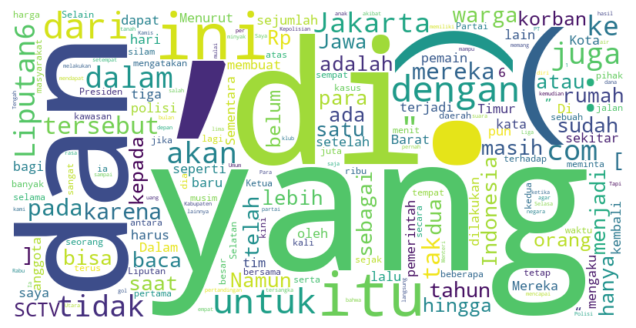

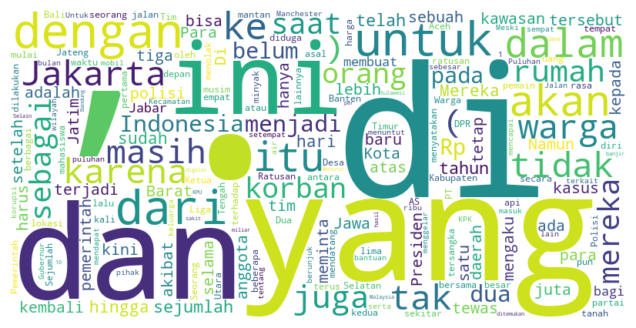

In [11]:
from collections import Counter
from wordcloud import WordCloud

dftrain_sample = df_train.sample(2000, random_state=42)
flatten_clean_article = sum(sum(dftrain_sample["clean_article"],[]),[])
flatten_clean_summary = sum(sum(dftrain_sample["clean_summary"],[]),[])

article_freq = Counter(flatten_clean_article)
article_cloud = WordCloud(width=800, height=400,background_color="white").generate_from_frequencies(article_freq)
plt.figure(figsize=(10,4))
plt.imshow(article_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

summary_freq = Counter(flatten_clean_summary)
summary_cloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(summary_freq)
plt.figure(figsize=(10,4))
plt.imshow(summary_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [12]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


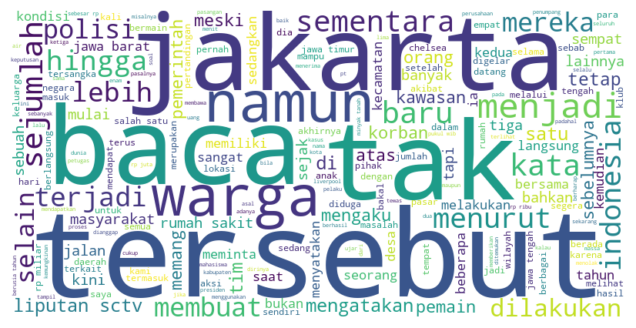

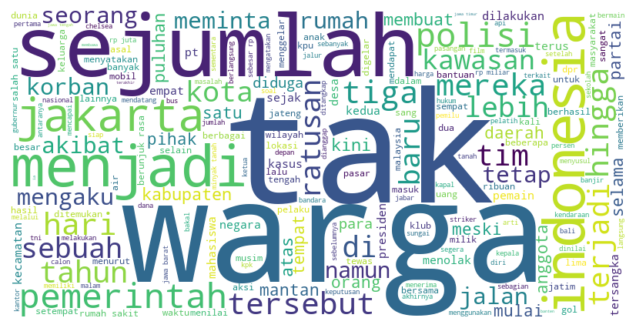

In [13]:
#percobaan hapus Stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())
filtered_article = [t.lower() for t in flatten_clean_article if t.isalpha() and t not in stopwords]
filtered_summary = [t.lower() for t in flatten_clean_summary if t.isalpha() and t not in stopwords]

article_cloud = WordCloud(width=800, height=400,background_color="white").generate(" ".join(filtered_article))
plt.figure(figsize=(10,4))
plt.imshow(article_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

summary_cloud = WordCloud(width=800, height=400,background_color="white").generate(" ".join(filtered_summary))
plt.figure(figsize=(10,4))
plt.imshow(summary_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
#detokenize clean_article dari raw data

dftrain_sample["detokenized_article"] = dftrain_sample["clean_article"].apply(lambda x: " ".join(sum(x,[])))
print(dftrain_sample["detokenized_article"].iloc[0])

Liputan6 . com , Pandeglang : Sebuah ledakan keras terjadi di Kampung Ciruang , Desa Pejamben , Kecamatan Carita , Pandeglang , Banten , Selasa ( 1/7 ) , sekitar pukul 13 . 30 WIB . Pusat ledakan di sebuah gubuk di kampung yang berjarak satu kilometer dari tempat rekreasi pantai Carita . Akibat ledakan dua orang tewas . Keduanya adalah Kobar dan Andri . Begitu dahsyatnya ledakan hingga tubuh mereka terlempar sejauh 10 meter dari tempat pusat ledakan . Selain merenggut korban jiwa ledakan juga membuat Darmin terluka parah . Belum diketahui penyebab ledakan . Namun , di sebuah rumah yang letaknya sekitar 50 meter dari lokasi ledakan polisi menemukan benda-benda yang biasa dijadikan bahan peledak , seperti belerang , potasium dan kabel . Sejak lima bulan lalu rumah itu dikontrak seorang pria bernama Sukardi yang kini menghilang . Guna mengungkap kasus ini polisi sudah memeriksa saksi-saksi termasuk Itap , pemilik rumah yang dikontrak Sukardi . Polisi juga terus menghimpun informasi tentan

In [15]:
#detokenized clean_summary dari raw data
dftrain_sample["detokenized_summary"] = dftrain_sample["clean_summary"].apply(lambda x: " ".join(sum(x,[])))
print(dftrain_sample["detokenized_summary"].iloc[0])

Dua orang tewas seketika akibat ledakan dahsyat di sebuah desa di Kecamatan Carita , Pandeglang , Banten . Di dekat lokasi ledakan polisi menemukan berbagai jenis bahan peledak .


In [16]:
dftrain_sample["detokenized_article"].head()

42855     Liputan6 . com , Pandeglang : Sebuah ledakan k...
136345    Liputan6 . com , Ottawa : Setelah keputusan De...
88528     Pelita Jaya Jawa Barat ( Jabar ) memperpanjang...
85788     Beberapa pekan terakhir , santer berkembang ru...
42360     Liputan6 . com , Depok : Anggota tubuh Mohamma...
Name: detokenized_article, dtype: object

In [17]:
dftrain_sample["detokenized_summary"].head()

42855     Dua orang tewas seketika akibat ledakan dahsya...
136345    Kanada menyetujui tindakan DK PBB dan akan iku...
88528     Pelita Jaya Jabar memperbaiki peringkatnya di ...
85788     Yaya Toure menepis kabar yang dihembuskan agen...
42360     Seorang bocah dari keluarga tak mampu di Depok...
Name: detokenized_summary, dtype: object

**2. Parse Kolom extractive_summary**

In [18]:
df_train["extractive_summary"].value_counts()

extractive_summary
[0, 1]            29927
[0, 2]            12327
[1, 2]            11231
[0, 3]             9499
[0, 4]             7376
                  ...  
[2, 13, 10]           1
[3, 37, 7]            1
[16, 31, 33]          1
[1, 24, 16, 8]        1
[2, 8, 3, 17]         1
Name: count, Length: 8471, dtype: int64

In [19]:
from nltk.tokenize import sent_tokenize

def extractive_summary_text(row):
    sentences = sent_tokenize(row["detokenized_article"])
    indices = row["extractive_summary"]
    if not isinstance(indices, list):
        return ""

    selected = [sentences[i] for i in indices if i < len(sentences)]
    return " ".join(selected)

In [20]:
dftrain_sample["extractive_text"] = dftrain_sample.apply(extractive_summary_text, axis=1)
dftrain_sample[["detokenized_article", "extractive_summary", "extractive_text"]].head()

,detokenized_article,extractive_summary,extractive_text
42855,"Liputan6 . com , Pandeglang : Sebuah ledakan k...","[2, 7]",30 WIB . Selain merenggut korban jiwa ledakan ...
136345,"Liputan6 . com , Ottawa : Setelah keputusan De...","[1, 4]","com , Ottawa : Setelah keputusan Dewan Keamana..."
88528,Pelita Jaya Jawa Barat ( Jabar ) memperpanjang...,"[0, 1]",Pelita Jaya Jawa Barat ( Jabar ) memperpanjang...
85788,"Beberapa pekan terakhir , santer berkembang ru...","[0, 4, 13]","Beberapa pekan terakhir , santer berkembang ru..."
42360,"Liputan6 . com , Depok : Anggota tubuh Mohamma...","[0, 4]","Liputan6 . Ibu Fahri , Sarifah , menyadari kel..."


**3. Text Preprocessing**

In [21]:
#custom stopwords & charachter cleaning

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

def remove_punctuation(text):
    text = text.lower()
    text = re.sub(r"liputan\s*6\s*\.\s*com", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords(text):
    return stopword_remover.remove(text)

def clean_article(text):
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

dftrain_sample["clean_article"] = dftrain_sample["detokenized_article"].apply(clean_article)
dftrain_sample["clean_summary"] = dftrain_sample["detokenized_summary"].apply(remove_punctuation)
dftrain_sample['extractive_text'] = dftrain_sample['extractive_text'].apply(clean_article)

In [22]:
dftrain_sample[["detokenized_article","clean_article"]].head(5)

,detokenized_article,clean_article
42855,"Liputan6 . com , Pandeglang : Sebuah ledakan k...",pandeglang sebuah ledakan keras terjadi kampun...
136345,"Liputan6 . com , Ottawa : Setelah keputusan De...",ottawa keputusan dewan keamanan pbb amerika se...
88528,Pelita Jaya Jawa Barat ( Jabar ) memperpanjang...,pelita jaya jawa barat jabar memperpanjang cat...
85788,"Beberapa pekan terakhir , santer berkembang ru...",beberapa pekan terakhir santer berkembang rumo...
42360,"Liputan6 . com , Depok : Anggota tubuh Mohamma...",depok anggota tubuh mohammad fahri lagi tumbuh...


In [23]:
dftrain_sample[["detokenized_summary","clean_summary"]].head(5)

,detokenized_summary,clean_summary
42855,Dua orang tewas seketika akibat ledakan dahsya...,dua orang tewas seketika akibat ledakan dahsya...
136345,Kanada menyetujui tindakan DK PBB dan akan iku...,kanada menyetujui tindakan dk pbb dan akan iku...
88528,Pelita Jaya Jabar memperbaiki peringkatnya di ...,pelita jaya jabar memperbaiki peringkatnya di ...
85788,Yaya Toure menepis kabar yang dihembuskan agen...,yaya toure menepis kabar yang dihembuskan agen...
42360,Seorang bocah dari keluarga tak mampu di Depok...,seorang bocah dari keluarga tak mampu di depok...


In [24]:
#NER baseline
ner_pipeline = pipeline(
    "ner",
    model = "cahya/bert-base-indonesian-NER",
    aggregation_strategy="simple",
    device=device
)

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [25]:
#ekstrak otomatis
def extract_entities_auto(text):
    try:
        ents = ner_pipeline(text)
        return [(e["word"], e["entity_group"]) for e in ents]
    except:
        return[]
    
dftrain_sample["entities"] = dftrain_sample["detokenized_article"].apply(extract_entities_auto)
dftrain_sample[["detokenized_article", "entities"]].head(10)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,detokenized_article,entities
42855,"Liputan6 . com , Pandeglang : Sebuah ledakan k...","[(liputan6. com, PRD), (pandeglang, GPE), (kam..."
136345,"Liputan6 . com , Ottawa : Setelah keputusan De...","[(liputan, PRD), (##6, ORG), (. com, PRD), (ot..."
88528,Pelita Jaya Jawa Barat ( Jabar ) memperpanjang...,"[(pelita jaya jawa barat, ORG), (jabar, ORG), ..."
85788,"Beberapa pekan terakhir , santer berkembang ru...","[(yaya toure, PER), (barcelona, ORG), (pep gua..."
42360,"Liputan6 . com , Depok : Anggota tubuh Mohamma...","[(liputan6. com, PRD), (depok, GPE), (mohammad..."
174038,"Liputan6 . com , Denpasar : Kunjungan wisatawa...","[(liputan, PRD), (##6, ORG), (. com, PRD), (de..."
34967,"Liputan6 . com , Semarang : Kharisma Rizki Pra...","[(liputan, PRD), (##6, ORG), (. com, PRD), (se..."
60984,"Liputan6 . com , Jakarta : Pakar politik Islam...","[(liputan6., ORG), (com, PRD), (jakarta, GPE),..."
110701,"Liputan6 . com , Jakarta : Tawa ceria anak-ana...","[(liputan, PRD), (##6, ORG), (. com, PRD), (ja..."
171843,"Liputan6 . com , Semarang : Ratusan orang dari...","[(liputan6. com, PRD), (semarang, GPE), (kesat..."


In [26]:
print(type(dftrain_sample["entities"].iloc[0]))
print(dftrain_sample["entities"].iloc[0])

<class 'list'>
[('liputan6. com', 'PRD'), ('pandeglang', 'GPE'), ('kampung ciruang', 'LOC'), ('desa pejamben', 'GPE'), ('kecamatan carita', 'GPE'), ('pandeglang', 'GPE'), ('banten', 'GPE'), ('selasa ( 1 / 7 )', 'DAT'), ('13. 30 wib', 'TIM'), ('satu kilometer', 'QTY'), ('pantai carita', 'LOC'), ('dua', 'CRD'), ('kob', 'PER'), ('andri', 'PER'), ('10 meter', 'QTY'), ('darmin', 'PER'), ('50 meter', 'QTY'), ('polisi', 'NOR'), ('pot', 'LOC'), ('kabel', 'LOC'), ('lima', 'CRD'), ('sukar', 'PER'), ('##di', 'PER'), ('ita', 'PER'), ('##di', 'PER'), ('sukar', 'LOC'), ('ian', 'PER'), ('agus', 'PER'), ('faisal', 'PER'), ('karim', 'PER')]


In [27]:
def merge_subwords(entities):
    merged = []
    buffer_word, buffer_type ="",""
    for word, typ in entities:
        if word.startswith("##"):
            buffer_word += word[2:]
        else:
            if buffer_word:
                merged.append((buffer_word, buffer_type))
            buffer_word, buffer_type = word, typ
        if buffer_word:
            merged.append((buffer_word, buffer_type))
            return merged
        
dftrain_sample["entities_merged"] = dftrain_sample["entities"].apply(merge_subwords)
dftrain_sample["entities_merged"]

42855              [(liputan6. com, PRD)]
136345                   [(liputan, PRD)]
88528     [(pelita jaya jawa barat, ORG)]
85788                 [(yaya toure, PER)]
42360              [(liputan6. com, PRD)]
                       ...               
188848             [(liputan6. com, PRD)]
107794             [(liputan6. com, ORG)]
170941                   [(liputan, PRD)]
159097                               None
103787             [(liputan6. com, PRD)]
Name: entities_merged, Length: 2000, dtype: object

In [28]:
#token ulang
tokenizer =BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

dftrain_sample["tokenized_article"] = dftrain_sample["clean_article"].apply(
    lambda x: tokenizer.tokenize(x)
)

dftrain_sample["tokenized_summary"] = dftrain_sample["clean_summary"].apply(
    lambda x: tokenizer.tokenize(x)
)

In [29]:
dftrain_sample["tokenized_article"].head().apply(lambda x: x[:30])

42855     [pandeglang, sebuah, ledakan, keras, terjadi, ...
136345    [ott, ##awa, keputusan, dewan, keamanan, pbb, ...
88528     [pelita, jaya, jawa, barat, jabar, memperpanja...
85788     [beberapa, pekan, terakhir, sant, ##er, berkem...
42360     [depok, anggota, tubuh, mohammad, fahri, lagi,...
Name: tokenized_article, dtype: object

In [30]:
dftrain_sample["tokenized_summary"].head().apply(lambda x: x[:30])

42855     [dua, orang, tewas, seketika, akibat, ledakan,...
136345    [kanada, menyetujui, tindakan, dk, pbb, dan, a...
88528     [pelita, jaya, jabar, memperbaiki, peringkat, ...
85788     [yay, ##a, tour, ##e, menep, ##is, kabar, yang...
42360     [seorang, bocah, dari, keluarga, tak, mampu, d...
Name: tokenized_summary, dtype: object

In [31]:
'''
Sampai sini dulu, saya gak lemmatization/ stemming 
khawatir mengganggu kealamian bahasanya karena menggunakan model BERT
'''

'\nSampai sini dulu, saya gak lemmatization/ stemming \nkhawatir mengganggu kealamian bahasanya karena menggunakan model BERT\n'

**4. Data Modeling**

A. Modeling untuk Abstractive Summary

In [32]:
#BERT model
#matrix ROUGE
#menggunakan data yg sudah dicleaning
#menggunakan subset data dari 20-30% populasi total data train

In [33]:
%pip install datasets rouge-score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
df_validate.head()

,id,url,clean_article,clean_summary,extractive_summary
0,1,https://www.liputan6.com/news/read/1/batas-pen...,"[[Liputan6, ., com, ,, Jakarta, :, Pemerintah,...","[[Pemerintah, memberikan, tenggat, 14, hari, k...","[1, 8]"
1,10,https://www.liputan6.com/news/read/10/belasan-...,"[[Liputan6, ., com, ,, Jakarta, :, Diperkiraka...","[[Satu, dari, 20, orang, Indonesia, diperkirak...","[2, 4]"
2,1000,https://www.liputan6.com/news/read/1000/lagi--...,"[[Liputan6, ., com, ,, Banda, Aceh, :, Aksi, p...","[[Peledakan, bom, kembali, terjadi, di, Aceh, ...","[2, 5]"
3,10000,https://www.liputan6.com/news/read/10000/penge...,"[[Liputan6, ., com, ,, Surabaya, :, Petugas, K...","[[Polres, Surabaya, Timur, menangkap, seorang,...","[0, 5]"
4,10001,https://www.liputan6.com/news/read/10001/menye...,"[[Liputan6, ., com, ,, Jakarta, :, Yogyakarta,...","[[Lima, seniman, Yogyakarta, dan, Bali, mengge...","[0, 2]"


In [ ]:
df_validate['clean_article'] = df_validate['clean_article'].apply(lambda x: " ".join(sum(x,[])))
df_validate['clean_summary'] = df_validate['clean_summary'].apply(lambda x: " ".join(sum(x,[])))

In [36]:
df_validate['clean_article'].iloc[0]

'Liputan6 . com , Jakarta : Pemerintah masih memberikan waktu dua minggu lagi kepada seluruh konglomerat yang telah menandatangani perjanjian pengembalian bantuan likuiditas Bank Indonesia dengan jaminan aset ( MSAA ) , untuk secepatnya menyerahkan jaminan pribadi serta aset . Jika lewat dari tenggat tersebut , pemerintah akan menerapkan tindakan hukum . Hal tersebut dikemukakan Menteri Koordinator Bidang Perekonomian Rizal Ramli di Jakarta , baru-baru ini . Rizal mengakui bahwa permintaan untuk meminta jaminan pribadi atau personal guarantee pada awalnya ditentang sejumlah konglomerat . Sebab para debitor menganggap tindakan tersebut memungkinkan pemerintah untuk menyita seluruh aset mereka baik yang berada di dalam maupun luar negeri . Sejauh ini , penilaian jaminan MSAA baru dilakukan atas aset milik Grup Salim . Tetapi , nilai aset yang dijaminkan Kelompok Salim atas utang BLBI Bank Central Asia diperkirakan tak lebih dari Rp 20 triliun . Padahal , kewajiban mereka mencapai Rp 52 t

In [38]:
df_test['clean_article'].iloc[0]

'Liputan6 . com , Jakarta : Kepolisian Daerah Riau bertekad memberantas pelaku penyelundupan kayu yang kerap terjadi di Riau . Selain itu , Polda setempat juga akan memberangus menipulasi dana reboisasi dan iuran hasil hutan . Demikian ditegaskan Kepala Polda Riau Brigadir Jenderal Polisi Johny Yodjana , seusai dilantik menjadi Kapolda Riau oleh Kepala Polri Jenderal Polisi Suroyo Bimantoro , di Jakarta , baru-baru ini . Menurut Johny , pelaku tindak kriminal yang kerap menjarah kayu di Riau akan ditindak tegas . " Saya tak akan pandang bulu , " janji Johny . Selain itu , ia bertekad menyelidiki dugaan manipulasi dana reboisasi dan iuran hasil hutan sebesar Rp 680 miliar yang dilakukan sebuah perusahaan kayu di Riau . Sementara itu , selain melantik Johny Yodyana , Kapolri juga melantik Inspektur Jenderal Polisi Firman Gani menjadi Kapolda Sulawesi Selatan dan Brigjen Pol . Eddy Darnadi menjadi Kapolda Maluku . Selain itu , Bimantoro juga melantik Komisaris Besar Pol . Totok Soenarjo m

In [ ]:
from datasets import Dataset

df = dftrain_sample[["clean_article", "clean_summary"]]
eval_df = df_validate[["clean_article", "clean_summary"]]
dataset = Dataset.from_pandas(df)
eval_dataset = Dataset.from_pandas(eval_df)

In [41]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    "indobenchmark/indobert-base-p1", "indobenchmark/indobert-base-p1"
)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of BertLMHeadModel were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.b

In [42]:
%pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
def preprocess_function(examples):
    inputs = tokenizer(examples['clean_article'], truncation=True, padding="max_length", max_length=512)
    targets = tokenizer(examples['clean_summary'], truncation=True, padding="max_length", max_length=128)
    inputs['labels'] = targets['input_ids']
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)
eval_tokenized_dataset = eval_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 10972/10972 [00:36<00:00, 303.93 examples/s]


In [44]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=6,
    per_device_eval_batch_size=1,
    num_train_epochs=10,
    logging_steps=10,
    eval_strategy="epoch",
    logging_dir='/results/runs',
    save_strategy='best',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=eval_tokenized_dataset,
)

trainer.train()

d:\project-indoai\Project 2\env-data\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
d:\project-indoai\Project 2\env-data\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch,Training Loss,Validation Loss
1,1.701500,1.653613
2,1.373000,1.552250
3,1.264600,1.511972
4,1.130500,1.492265
5,1.012800,1.487740
6,0.902000,1.486331
7,0.755700,1.491912
8,0.657800,1.501829
9,0.634000,1.503641
10,0.615800,1.509478


d:\project-indoai\Project 2\env-data\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
d:\project-indoai\Project 2\env-data\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
d:\project-in

TrainOutput(global_step=3340, training_loss=1.0939572888220142, metrics={'train_runtime': 25978.5221, 'train_samples_per_second': 0.77, 'train_steps_per_second': 0.129, 'total_flos': 1.227027873792e+16, 'train_loss': 1.0939572888220142, 'epoch': 10.0})

In [45]:
trainer.evaluate()

{'eval_loss': 1.5094783306121826,
 'eval_runtime': 1727.0986,
 'eval_samples_per_second': 6.353,
 'eval_steps_per_second': 6.353,
 'epoch': 10.0}

In [46]:
trainer.save_model('./abstractive-summary')

**4. Model Evaluation**

In [3]:
df_test['clean_article'] = df_test['clean_article'].apply(lambda x: " ".join(sum(x,[])))
df_test['clean_summary'] = df_test['clean_summary'].apply(lambda x: " ".join(sum(x,[])))

In [4]:
model = EncoderDecoderModel.from_pretrained('./abstractive-summary')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [5]:
from transformers import GenerationConfig
model.generation_config = GenerationConfig.from_model_config(model.config)

In [11]:
import random
from rouge_score import rouge_scorer

sum_rouge1 = 0
sum_rouge2 = 0
sum_rougeL = 0

avg_rouge1 = 0
avg_rouge2 = 0
avg_rougeL = 0

len_data_test = 3

for loop in range(len_data_test):

    i = random.randint(0, len(df_test['clean_article']))

    inputs = tokenizer(
    df_test['clean_article'].iloc[i],
    return_tensors="pt",
    truncation=True, padding="max_length", max_length=512
    )

    summary_ids = model.generate(
    **inputs,
    max_length=128,
    num_beams=4,
    early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    ref_summary = df_test['clean_summary'].iloc[i]

    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(ref_summary, summary)

    print(f"Data ID: {i}")
    print(f"Summary Reference:\n{ref_summary}")
    print(f"Model Summaries:\n{summary}\n")
    print(f"ROUGE-1 Score: {scores["rouge1"].fmeasure}")
    print(f"ROUGE-2 Score: {scores["rouge2"].fmeasure}")
    print(f"ROUGE-L Score: {scores["rougeL"].fmeasure}\n\n")

    sum_rouge1 += scores["rouge1"].fmeasure
    sum_rouge2 += scores["rouge2"].fmeasure
    sum_rougeL += scores["rougeL"].fmeasure

    if loop == len_data_test - 1:
        break

avg_rouge1 = sum_rouge1 / len_data_test
avg_rouge2 = sum_rouge2 / len_data_test
avg_rougeL = sum_rougeL / len_data_test

print(f"Average Rouge Score for {len_data_test} Data:")
print(f"ROUGE-1: {avg_rouge1}")
print(f"ROUGE-2: {avg_rouge2}")
print(f"ROUGE-L: {avg_rougeL}")

Data ID: 6455
Summary Reference:
Pasukan bantuan TNI siap diterjunkan untuk mengantisipasi aksi sweeping . Kasus sweeping masih berada dalam batas kewajaran yang dapat ditangani Polri .
Model Summaries:
tni tak akan memberikan bantuan kepada tni untuk mengantisipasi serangan udara amerika serikat untuk menyelesaikan aksi militer di amerika serikat

ROUGE-1 Score: 0.25
ROUGE-2 Score: 0.05263157894736842
ROUGE-L Score: 0.25


Data ID: 9932
Summary Reference:
DPP PKB dalam waktu dekat akan menggelar muktamar luar biasa . Langkah ini dipercaya mampu menyelesaikan konflik internal jika jalan informal sudah menemui jalan buntu .
Model Summaries:
pertemuan itu akan dilakukan untuk menyelesaikan konflik antara pkb di yogyakarta dan jakarta pertemuan itu akan dilakukan untuk menyelesaikan konflik dengan pkb di jakarta

ROUGE-1 Score: 0.16666666666666666
ROUGE-2 Score: 0.043478260869565216
ROUGE-L Score: 0.16666666666666666


Data ID: 2535
Summary Reference:
Polres Kapuas Kalimantan Tengah terus